# FinOMOP ML model AML v1 : data extract

Author: Salma Rachidi, Eric Fey (eric.fey@hus.fi)  
Version: v0.3  
Date: 2023-10-31

This python jupyter notebook extracts and transforms the required data for the FinOMOP AML model from the OMOP database.
The notebook will generate a csv file containing the data. 

**How to use?**  
The connection details for your OMOP database need to be configured according to your setup. 
Then run the notebook. 


<details><summary><b>Description:</b> (click for details)</summary>

The purpose of this notebook is to extact some data from HUS OMOP for testing the OMOP data annomyzation process using a specific use case. 
The use case is the data required for the FinOMOP AML model v1.0.

Cohort: AML patients. Patients with AML diagnosis (and AML descendant concepts) are selected.  

Overview of data:

  - persons: Clinical variables characterising the cohort. Several OMOP tables are joined to get this info:
      - condition_occurrence
      - death
      - person
      - visit_occurrence
  - measurements: A selected set of measurement variables for the cohort. The following measurements are needed (number = concept_id):
      - 3022250, # LDH
      - 3000963, # Hemoglobin
      - 3010813, # Leukocytes [#/volume] in Blood
      - 3009992, # Blasts/100 cells in Bone marrow
      - 3025159, # Blasts/100 leukocytes in Blood	
      - 3007461, # Platelets [#/volume] in Blood
      - 3002030, # Lymphocytes/100 leukocytes in Blood	
      - 3019069, # Monocytes/100 leukocytes in Blood	
      - 3018010, # Neutrophils/100 leukocytes in Blood
      - 3006504, # Eosinophils/100 leukocytes in Blood
      - 3022096, # Basophils/100 leukocytes in Blood	
      - 3032352, # Blasts [#/volume] in Cerebral spinal fluid
      - 3042111, #Morphology [Interpretation] in Bone marrow
  - observations: not needed for v1.0
  - procedures: not needed for v1.0
  - drugs: not needed for v1.0

Link to diagram: https://drive.google.com/file/d/1Ub7o1xdKIqfpnBFrXLfym1lUdD7x5xmJ/view?usp=sharing

The required table for the model is (after data-preprocessing, pseudo-annomyzation, and filtering) saved in the current working dorectory as 
    - df_xy_tmp.csv
    
For the model, only timepoints reltive to the date of first diagnosis are needed (no exact dates).  
</details>
&nbsp;
    
**Todo:**
- [ ] Add OMOP connection configs for VARHA and PIRHA
- [ ] Adapt to use SQLAlchemy for HUS with paramterized queries.


In [132]:
import numpy as np  
import pandas as pd
from datetime import date, timedelta
import sqlalchemy 
from sqlalchemy import create_engine, text
import pyodbc
import getpass

# HUS specific code to connect to the OMOP database that needs to be replaced according to your database:
# For SQLServer using the pyodbc driver:
server = 'tcp:husfd-tu-omop-sqls.database.windows.net' 
database = 'hfdtu1052022ecare4meb2' 
username = 'ext-dirk.fey@hustietoallas.fi' 
#username = 'EXT19616221@hustietoallas.fi'
# Direct odbc connection:
con = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ getpass.getpass() +";Authentication=ActiveDirectoryPassword")
cursor = con.cursor()
cursor.execute("select 'Connection successful!';").fetchall()[0][0]
#SQLAlchemt connection:
#engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect=DRIVER%3D%7BODBC+Driver+17+for+SQL+Server%7D%3BSERVER%3Dtcp%3Ahusfd-tu-omop-sqls.database.windows.net%3BDATABASE%3Dhfdtu1052022ecare4meb2%3BUID%3Dext-dirk.fey%40hustietoallas.fi%3BPWD%3D"+getpass.getpass("Password:")+"%3BAuthentication%3DActiveDirectoryPassword", echo=True)
#with engine.connect() as connection:
#    result = connection.execute(text("select 1;")).all()
#result
#con = engine.connect()
#con.execute(text("select 'Connection successful!'")).all()[0][0]

# VARHA specific connection details:
# For example: Using PostgreSQL and the psycopg driver:
#import psycopg2
#import getpass
#from sqlalchemy import create_engine
#pw = getpass.getpass()
#con = psycopg2.connect(host='xxx', port = '5432', user='xxx' , password = pw, dbname='omop')

# PIRHA specific connection details:
#server = 'YOURSERVER' 
#database = 'YOURDATABASE' 
#username = 'YOURUSERNAME' 
#con = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ getpass.getpass())
#cursor = con.cursor()
#cursor.execute("select 'Connection successful!';").fetchall()[0][0]


 ········


'Connection successful!'

In [107]:
os.chdir('../FinOMOP-SL')
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/eric-ci03/code/Users/ext-dirk.fey/FinOMOP-SL'

In [133]:
# For HUS:
schema = "omop_2023_06_21"
parameter = "(?)"
# For VARHA: 
#schema = "cdm"
#parameter = "(%s)"
# For PIRHA:

## Get data

Uee concept_id 140352 for Acute myeloid leukemia (AML). 
The following cell generates the cohort by inlcuding all descendents concepts, using informatoin from several OMOP tables:
condition_occurrence, person, death, visit_occurrence. 
Patients (persons) for which no visit_occurence record exists are filtered out (required at HUS to exclude potential non-HUS patients that might exists in the database.)

Notes: 
 - first diagnosis is defined as first occurrence of an AML condition
 - last followup is defined as last day of last visit

In [136]:
AML_concept = 140352 # 140352 AML
sql1 = """
-- This creates table with person_id, diagnosis_start date.
-- It inlcudes the condition and its descendents 
SELECT ce.person_id, MIN(condition_start_date) AS diagnosis_first, MAX(condition_end_date) AS diagnosis_last, 
    MIN(death_date) AS death_date, MIN(cause_concept_id) AS death_cause,
    -- include age at diagnosis (EF: removed because DATEDIFF function not uniform across SQL dialects -> calculate in python):
    -- MIN( DATEDIFF(year, p.birth_datetime, condition_start_date) ) AS age_at_diagnosis,
    MIN(p.year_of_birth) AS year_of_birth, 
    -- inlcude gender:
    CASE 
        WHEN MIN(gender_concept_id) = 8507 THEN 'male'
        WHEN MIN(gender_concept_id) = 8532 THEN 'female'
        ELSE 'other'
    END gender,
    -- inlcude last follow up (important when death_date empty), here based on visit_occurrence:
    MAX( vo.visit_end_date) AS last_followup
FROM @schema.condition_occurrence ce
--JOIN @schema.concept ON condition_concept_id = concept_id
-- inlcude death:
LEFT JOIN @schema.DEATH d ON ce.person_id = d.person_id
-- inlcude info from persons:
LEFT JOIN @schema.PERSON p ON ce.person_id = p.person_id
-- inlcude visits:
LEFT JOIN @schema.visit_occurrence vo ON ce.person_id = vo.person_id
-- inlcude condition and its descendants:
WHERE condition_concept_id IN ( --Conditions descendants
    SELECT concept_id FROM @schema.concept
    INNER JOIN @schema.concept_ancestor AS a
    ON concept_id = descendant_concept_id  /* Get descendant names */
    WHERE ancestor_concept_id = @parameter        /* Fix ancestor  */ 
    AND standard_concept = 'S' AND concept_class_id = 'Clinical Finding'
)
GROUP BY ce.person_id
""".replace("@schema", schema).replace("@parameter", parameter)
#print(sql1)
persons = pd.read_sql(sql1, con, params=[AML_concept])
#persons.head(5)
print(persons.shape[0])

1757


In [110]:
sql2 = """
--SELECT * FROM @schema.MEASUREMENT 
SELECT person_id, concept_name AS measurement_name, measurement_concept_id, measurement_date, value_as_number, value_as_concept_id, unit_concept_id 
FROM @schema.MEASUREMENT
JOIN @schema.CONCEPT ON measurement_concept_id = concept_id
WHERE person_id IN (
    --persons with condition
    SELECT DISTINCT person_id 
    FROM @schema.condition_occurrence ce
    WHERE condition_concept_id IN ( 
        --conditions descendants
        SELECT concept_id FROM @schema.concept
        INNER JOIN @schema.concept_ancestor AS a
        ON concept_id = descendant_concept_id  /* Get descendant names */
        WHERE ancestor_concept_id = @parameter        /* Fix ancestor  */ 
        AND standard_concept = 'S' AND concept_class_id = 'Clinical Finding'
        )
    )
    AND measurement_concept_id != 0
""".replace("@schema", schema).replace("@parameter", parameter)
measurement = pd.read_sql(sql2, con, params=[AML_concept])
print(measurement.shape[0])

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


8081551


In [111]:
sql3 = """
--SELECT * FROM @schema.OBSERVATION 
SELECT person_id, concept_name AS observation_name, observation_concept_id, observation_date, value_as_number, value_as_string, value_as_concept_id, qualifier_concept_id, unit_concept_id
FROM @schema.OBSERVATION
INNER JOIN @schema.CONCEPT ON observation_concept_id = concept_id
WHERE person_id IN (
    --persons with condition
    SELECT DISTINCT person_id 
    FROM @schema.condition_occurrence ce
    WHERE condition_concept_id IN ( 
        --conditions descendants
        SELECT concept_id FROM @schema.concept
        INNER JOIN @schema.concept_ancestor AS a
        ON concept_id = descendant_concept_id  /* Get descendant names */
        WHERE ancestor_concept_id = @parameter        /* Fix ancestor  */ 
        AND standard_concept = 'S' AND concept_class_id = 'Clinical Finding'
        )
    )
    AND observation_concept_id != 0
""".replace("@schema", schema).replace("@parameter", parameter)
observation = pd.read_sql(sql3, con, params=[AML_concept])
print(observation.shape[0])

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


95610


In [112]:
sql4 = """
--SELECT * FROM @schema.PROCEDURE_OCCURRENCE 
SELECT person_id, concept_name AS procedure_name, procedure_concept_id, procedure_date, procedure_type_concept_id, modifier_concept_id
FROM @schema.PROCEDURE_OCCURRENCE
INNER JOIN @schema.CONCEPT ON procedure_concept_id = concept_id
WHERE person_id IN (
    --persons with condition
    SELECT DISTINCT person_id 
    FROM @schema.condition_occurrence ce
    WHERE condition_concept_id IN ( 
        --conditions descendants
        SELECT concept_id FROM @schema.concept
        INNER JOIN @schema.concept_ancestor AS a
        ON concept_id = descendant_concept_id  /* Get descendant names */
        WHERE ancestor_concept_id = @parameter        /* Fix ancestor  */ 
        AND standard_concept = 'S' AND concept_class_id = 'Clinical Finding'
        )
    )
    AND procedure_concept_id != 0
""".replace("@schema", schema).replace("@parameter", parameter)
procedure = pd.read_sql(sql4, con, params=[AML_concept])
print(procedure.shape[0])

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


107631


In [113]:
sql5 = """
SELECT person_id, concept_name AS drug_name, drug_concept_id, 
    drug_exposure_start_date AS date,
    drug_exposure_end_date AS end_date 
FROM @schema.DRUG_EXPOSURE
INNER JOIN @schema.CONCEPT ON drug_concept_id = concept_id
WHERE person_id IN (
    --persons with condition
    SELECT DISTINCT person_id 
    FROM @schema.condition_occurrence ce
    WHERE condition_concept_id IN ( 
        --conditions descendants
        SELECT concept_id FROM @schema.concept
        INNER JOIN @schema.concept_ancestor AS a
        ON concept_id = descendant_concept_id         /* Get descendant names */
        WHERE ancestor_concept_id = @parameter        /* Fix ancestor  */ 
        AND standard_concept = 'S' AND concept_class_id = 'Clinical Finding'
        )
    )
    AND drug_concept_id != 0  /* Filter out unmapped drugs */
""".replace("@schema", schema).replace("@parameter", parameter)
drug = pd.read_sql(sql5, con, params=[AML_concept])
print(drug.shape[0])

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


379803


## Data pre-processing for dates

In [140]:
# Data processing (increase pseudo-annomysation): calculate dates with respect to first diagnosis:
dateformat="datetime64[ns]"
persons = (
    persons
    # make sure date colums are of type datetime 
    .assign(diagnosis_first = lambda x: x.diagnosis_first.astype(dateformat))
    .assign(diagnosis_last =  lambda x: x.diagnosis_last.astype(dateformat))
    .assign(death_date =      lambda x: x.death_date.astype(dateformat))
    .assign(last_followup =   lambda x: x.last_followup.astype(dateformat))
    # instead of exact dates use realtive time: time from diagnosis in days:
    .assign(diagnosis_last_time = lambda x: (x.diagnosis_last - x.diagnosis_first) / pd.Timedelta(days=1) )
    .assign(death_time          = lambda x: (x.death_date     - x.diagnosis_first) / pd.Timedelta(days=1) )
    .assign(last_followup_time  = lambda x: (x.last_followup  - x.diagnosis_first) / pd.Timedelta(days=1) )
    # calculate age at first diagnosis
    .assign(age_at_diagnosis    = lambda x: (x.diagnosis_first.dt.year - x.year_of_birth) )
)
#persons.head(5)
#persons.info()

In [115]:
# make sure dates are of type datetime in the other tables:
measurement = (
    measurement
    .assign(measurement_date = lambda x: x.measurement_date.astype("datetime64[ns]"))
)
observation = (
    observation
    .assign(observation_date = lambda x: x.observation_date.astype("datetime64[ns]"))
)
procedure = (
    procedure
    .assign(procedure_date = lambda x: x.procedure_date.astype("datetime64[ns]"))
)

In [141]:
# make tables that inlcudes 1st diagnosis date
if "diagnosis_first" not in measurement.columns :
    measurement = pd.merge(measurement, persons[["person_id", "diagnosis_first"]], how = 'left', on = 'person_id')
if "diagnosis_first" not in observation.columns :
    observation = pd.merge(observation, persons[["person_id", "diagnosis_first"]], how = 'left', on = 'person_id')
if "diagnosis_first" not in procedure.columns :
    procedure = pd.merge(procedure, persons[["person_id", "diagnosis_first"]], how = 'left', on = 'person_id')

# Include time as days from first diagnosis
measurement = measurement.assign(time = lambda x: (x.measurement_date-x.diagnosis_first) / pd.Timedelta(days=1) )
observation = observation.assign(time = lambda x: (x.observation_date-x.diagnosis_first) / pd.Timedelta(days=1) )
procedure = procedure.assign(time = lambda x: (x.procedure_date-x.diagnosis_first) / pd.Timedelta(days=1) )    

print(f"Number of patients: {persons.shape[0]:,.0f}")
print(f"Number of measurements: {measurement.shape[0]:,.0f}")
print(f"Number of observations: {observation.shape[0]:,.0f}")
print(f"Number of procedures: {procedure.shape[0]:,.0f}")


Number of patients: 1,757
Number of measurements: 8,081,551
Number of observations: 95,610
Number of procedures: 107,631


## Data preprocessing


### Filter relevant measurements

These are the most appropiate OMOP concepts identified so far (based on the data from all hospitals only).

In [117]:
# Select key concepts
myvars = [
    3022250, # LDH
    3000963, # Hemoglobin
    3010813, # Leukocytes [#/volume] in Blood
    3009992, # Blasts/100 cells in Bone marrow
    3025159, # Blasts/100 leukocytes in Blood	
    3007461, # Platelets [#/volume] in Blood
    3002030,	# Lymphocytes/100 leukocytes in Blood	
    3019069,	# Monocytes/100 leukocytes in Blood	
    3018010,	# Neutrophils/100 leukocytes in Blood
    3006504,	# Eosinophils/100 leukocytes in Blood
    3022096,	# Basophils/100 leukocytes in Blood	
]

measurement_f1 = (
    measurement
    .query("measurement_concept_id in @myvars")
    .filter(["measurement_concept_id", "measurement_name", "person_id", "value_as_number", "time"])
    .query("time >= -5 and time <=21")
    .sort_values("time")
    .sort_values(["person_id", "time"]) 
)

measurement_f1.head(50)

# Clean data
#measurement_f2 = (
#    measurement_f1
#    .filter(["measurement_concept_id", "measurement_name", "person_id", "value_as_number", "unit_concept_id", "measurement_date", "diagnosis_first"])
#    .assign(measurement_days_from_diag = lambda x: (x.measurement_date-x.diagnosis_first) / pd.Timedelta(days=1) )
#    #time window < 365 days:
#    .query("measurement_days_from_diag < 366")
#)

# Make table with total numbers per concept (1. Number of persons with measurements available, 2. Total number of measurements)
#variables = (
#    measurement_f2
#    .query("measurement_concept_id in @myvars")
#    .groupby(["measurement_concept_id", "measurement_name"],  as_index=False)
#    .agg(n_person_with_meas=("person_id","nunique"),
#         n_meas_tot=("person_id","count"),
#         #avg_meas_per_person=("person_id","") 
#        )
#    .sort_values("n_person_with_meas", ascending=False)
#)

,measurement_concept_id,measurement_name,person_id,value_as_number,time
15684,3018010,Neutrophils/100 leukocytes in Blood,3233,14.0,1.0
11441,3010813,Leukocytes [#/volume] in Blood,3233,23.8,1.0
2088,3002030,Lymphocytes/100 leukocytes in Blood,3233,20.0,1.0
8580,3007461,Platelets [#/volume] in Blood,3233,44.0,1.0
821,3000963,Hemoglobin [Mass/volume] in Blood,3233,129.0,1.0
16436,3019069,Monocytes/100 leukocytes in Blood,3233,15.0,1.0
24763,3025159,Blasts/100 leukocytes in Blood,3233,51.0,1.0
22189,3022250,Lactate dehydrogenase [Enzymatic activity/volu...,3233,602.0,1.0
22212,3022250,Lactate dehydrogenase [Enzymatic activity/volu...,3233,654.0,2.0
8527,3007461,Platelets [#/volume] in Blood,3233,87.0,2.0


## Overview of patient cohort

In [161]:
cohort_stats_gender = (
    persons
    .groupby("gender")
    .agg(
        patients = ("person_id", "nunique"),
        age_median = ("age_at_diagnosis", "median"),
        #age_min = ("age_at_diagnosis", "min"),
        #age_max = ("age_at_diagnosis", "max"),
        followup_days = ("last_followup_time", "median")
    )
).transpose()
cohort_stats_gender.columns.name=None
cohort_stats_gender.pipe(display)

,female,male
patients,885.0,872.0
age_median,60.0,59.0
followup_days,554.0,527.5


## Overview of measurments

In [118]:
# Make table with total numbers per concept (1. Number of persons with measurements available, 2. Total number of measurements)
variables = (
    measurement_f1
    .filter(["measurement_concept_id", "measurement_name", "person_id", "value_as_number", "unit_concept_id", "time"])
    .query("measurement_concept_id in @myvars")
    .groupby(["measurement_concept_id", "measurement_name"],  as_index=False)
    .agg(n_person_with_meas=("person_id","nunique"),
         n_meas_tot=("person_id","count"),
         #avg_meas_per_person=("person_id","") 
        )
    .sort_values("n_person_with_meas", ascending=False)
)

# Make table with per-person numbers for each concept (average (median) number of measurements per person, etc.):
variables_perperson = (
    measurement_f1
    .filter(["measurement_concept_id", "measurement_name", "person_id", "value_as_number", "unit_concept_id", "time"])
    #.query("measurement_concept_id in @myvars")
    # 1. Calculate per person statistics:
    .groupby(["measurement_concept_id", "measurement_name", "person_id"],  as_index=False)
    .agg(n_meas=("value_as_number","count"),
         meas_first=("time","min"),
         meas_last=("time","max")
        )
    # 2. Calculate average per person stats:
    .groupby(["measurement_concept_id", "measurement_name"],  as_index=False)
    .agg(avg_n_meas=("n_meas","median"),
         min_n_meas=("n_meas","min"),
         max_n_meas=("n_meas","max"),
         avg_meas_first=("meas_first","median"),
         #med_meas_first=("meas_first","median"),
         avg_meas_last=("meas_last","median")
        )
    #.mean() #doeas not work for datediff datatype
    .sort_values("avg_n_meas", ascending=False)
)

# Merge both tables and show result
print("Patient numbers per measurement concept:")
variables = pd.merge(variables, variables_perperson.drop("measurement_name", axis=1), on="measurement_concept_id")
variables


Patient numbers per measurement concept:


,measurement_concept_id,measurement_name,n_person_with_meas,n_meas_tot,avg_n_meas,min_n_meas,max_n_meas,avg_meas_first,avg_meas_last
0,3000963,Hemoglobin [Mass/volume] in Blood,1456,21814,15.0,1,254,0.0,21.0
1,3007461,Platelets [#/volume] in Blood,1456,20801,15.0,1,73,0.0,21.0
2,3010813,Leukocytes [#/volume] in Blood,1456,20817,15.0,1,74,0.0,21.0
3,3002030,Lymphocytes/100 leukocytes in Blood,1399,6915,4.0,1,28,0.0,14.0
4,3019069,Monocytes/100 leukocytes in Blood,1386,6320,4.0,1,24,0.0,13.0
5,3018010,Neutrophils/100 leukocytes in Blood,1376,6271,4.0,1,25,0.0,13.0
6,3006504,Eosinophils/100 leukocytes in Blood,1285,4828,3.0,0,23,0.0,12.0
7,3022096,Basophils/100 leukocytes in Blood,1217,4245,3.0,0,23,0.0,12.0
8,3022250,Lactate dehydrogenase [Enzymatic activity/volu...,1156,7124,6.0,1,47,0.0,18.0
9,3025159,Blasts/100 leukocytes in Blood,746,3105,4.0,0,23,0.0,6.0


## Prepare data for model

Prepare wide, tidy tables inlcuding overall survival, and all features (measurements at differnet timepoints).
The table contains many missing values (NaNs).

Overall survival:
 - OSS_days: overall surval time (days) 
 - OSS_status: (1-death, 0-censored)

### Bring into wide format (timepoints as columns)

In [119]:
#pivot cannot handle duplicate indicies:
measurement_f1.query("time>=-5 and time<=21").head(100).sort_values(['measurement_name', 'time']).pivot(index=['person_id'], columns=['measurement_name', 'time'], values=['value_as_number'])
# ...but pivot table can, using aggregates

m_wide=(
    measurement_f1
    #.query("time>=-5 and time<=21")#.head(500)
    .sort_values(['measurement_name', 'time'])
    .pivot_table(index=['person_id'], columns=['measurement_name', 'time'], values=['value_as_number'], 
                 aggfunc = "mean", fill_value = None, margins = False)
)
#m_wide.pipe(display)

array([<AxesSubplot:ylabel='Frequency'>], dtype=object)

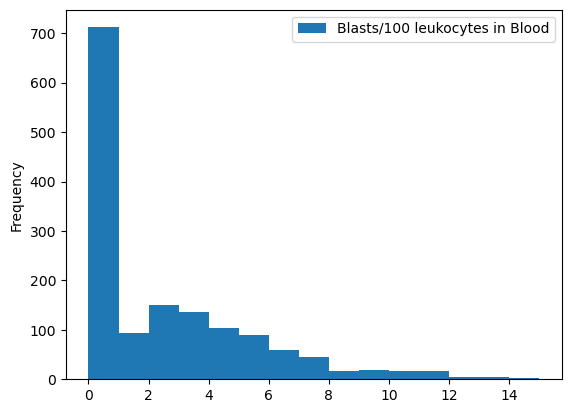

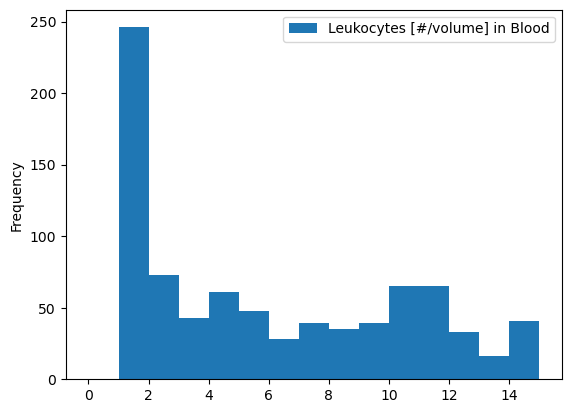

In [120]:
# How many timepoints per measurements for each patient?
m_numbers = (
    m_wide    
    .groupby(axis=1, level=1)
    .count()
    .sort_values("Blasts/100 leukocytes in Blood", ascending=False)
)
#m_numbers.pipe(display)
m_numbers.plot(y=["Blasts/100 leukocytes in Blood"], kind='hist', subplots=True, sharex=False, bins=[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15])

# How many timepoints per measurements for each patient?
m_numbers = (
    m_wide    
    .groupby(axis=1, level=1)
    .count()
    .sort_values("Leukocytes [#/volume] in Blood", ascending=False)
)
#m_numbers.pipe(display)
m_numbers.plot(y=["Leukocytes [#/volume] in Blood"], kind='hist', subplots=True, sharex=False, bins=[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15])

### How many patients with at least 3 blast measurements?

In [121]:
df_x = m_wide.loc[m_numbers.query("`Blasts/100 leukocytes in Blood` >= 2").index,:].droplevel(level=0, axis=1)
print(f"Number of patients with at least 3 blast measurements: {df_x.shape[0]}")

Number of patients with at least 3 blast measurements: 650


### Tidy x data for the model

In [122]:
# Flatten index
df_x = m_wide.loc[m_numbers.query("`Blasts/100 leukocytes in Blood` >= 2").index,:].droplevel(level=0, axis=1)
#df_x.columns = df_x.columns.to_flat_index()
#df_x

### Tidy y data for model

In [123]:
# Calculate overall surval time (days) and status (1-death, 0-censored)
df_y = (
    persons
    .assign(OSS_days = lambda x: np.where( np.isnan(x["death_time"].astype("float")), x.last_followup_time, x.death_time))
    .assign(OSS_status = lambda x: np.where( np.isnan(x["death_time"].astype("float")), 0, 1))    
)
#df_y.pipe(display)

### Join x and y data for tidy data

In [124]:
df_xy = df_y[["person_id","OSS_days", "OSS_status"]].set_index("person_id")
df_xy = df_xy.set_axis([["OSS_days", "OSS_status"], ['I', 'II']], axis='columns').join(df_x, how="inner")
df_xy

OSS_days OSS_status Basophils/100 leukocytes in Blood            \
                 I         II                              -5.0 -4.0 -3.0   
person_id                                                                   
3233        2925.0          0                               NaN  NaN  NaN   
5298        2206.0          0                               NaN  NaN  1.0   
10595         53.0          1                               NaN  NaN  NaN   
11570         21.0          1                               NaN  NaN  NaN   
18144         44.0          1                               NaN  NaN  NaN   
...            ...        ...                               ...  ...  ...   
3454477      145.0          1                               NaN  NaN  NaN   
3455802      744.0          0                               NaN  NaN  NaN   
3475910     1012.0          1                               NaN  NaN  NaN   
3498197     5630.0          0                               NaN  NaN  NaN   
3526841        8.0          1                               NaN  NaN  NaN   

                                    ... Platelets [#/volume] in Blood        \
          -2.0 -1.0  0.0  1.0  2.0  ...                          12.0  13.0   
person_id                           ...                                       
3233       NaN  NaN  NaN  NaN  NaN  ...                          20.0  54.0   
5298       NaN  NaN  NaN  NaN  NaN  ...                          15.0   7.0   
10595      NaN  1.0  NaN  NaN  NaN  ...                           NaN   NaN   
11570      NaN  NaN  NaN  NaN  NaN  ...                          32.0  19.0   
18144      NaN  NaN  1.0  NaN  NaN  ...                         110.0  88.0   
...        ...  ...  ...  ...  ...  ...                           ...   ...   
3454477    NaN  NaN  4.0  NaN  NaN  ...                          49.5  53.0   
3455802    NaN  NaN  0.5  NaN  1.0  ...                          64.0  47.0   
3475910    NaN  NaN  NaN  NaN  NaN  ...                          26.0  22.0   
3498197    NaN  NaN  NaN  NaN  NaN  ...                          18.0  94.0   
3526841    NaN  NaN  NaN  0.0  1.0  ...                           NaN   NaN   

                                                                 
           14.0   15.0   16.0   17.0   18.0  19.0   20.0   21.0  
person_id                                                        
3233       31.0   22.0   20.0   10.0   29.0  22.0   15.0   10.0  
5298       52.0   34.0   21.0   11.0   45.0  32.0   21.0   15.0  
10595       NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN  
11570      39.0   26.0   36.0   30.0   29.0  35.0   20.0    6.0  
18144      80.0  102.0  215.0  242.0  235.0   NaN  169.0  160.0  
...         ...    ...    ...    ...    ...   ...    ...    ...  
3454477    23.0   16.0   37.0   18.0   58.0  35.0   17.0   43.0  
3455802    35.0   21.0   48.0   36.0   24.0  16.0    9.0   40.0  
3475910    13.0    NaN    4.0   63.0    NaN   NaN   17.0    NaN  
3498197    59.0   40.0   18.0   65.0   41.0  28.0   18.0   66.0  
3526841     NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN  

[650 rows x 284 columns]

### Save tidy table into csv file

In [125]:
# Save table into flat file (csv)
# df_xy.head(5).to_csv("df_xy_test.csv")
filename = "df_xy_tmp.csv"
df_xy.to_csv("df_xy_tmp.csv")

## Summary

The pseudo-annonomyzed data for the model shouls now be in a csv file in the working directory.

In [126]:
import os
print(f"Working directory: {os.getcwd()}")
print(f"Data file: {filename}")

Working directory: /mnt/batch/tasks/shared/LS_root/mounts/clusters/eric-ci03/code/Users/ext-dirk.fey/FinOMOP-SL
Data file: df_xy_tmp.csv
